# Сборный проект - 2
____

## Описание данных
### Технологический процесс
* **`Rougher feed`** — исходное сырье
* **`Rougher additions (или reagent additions)`** — флотационные реагенты: Xanthate, Sulphate, Depressant
* **`Xanthate`** — ксантогенат (промотер, или активатор флотации);
* **`Sulphate`** — сульфат (на данном производстве сульфид натрия);
* **`Depressant`** — депрессант (силикат натрия).
* **`Rougher process`** (англ. «грубый процесс») — флотация
* **`Rougher tails`** — отвальные хвосты
* **`Float banks`** — флотационная установка
* **`Cleaner process`** — очистка
* **`Rougher Au`** — черновой концентрат золота
* **`Final Au`** — финальный концентрат золота

### Параметры этапов
* **`air amount`** — объём воздуха
* **`fluid levels`** — уровень жидкости
* **`feed size`** — размер гранул сырья
* **`feed rate`** — скорость подачи

### Наименование признаков
Наименование признаков должно быть такое:
[этап].[тип_параметра].[название_параметра]  
*Пример: rougher.input.feed_ag*  
Возможные значения для блока [этап]:
* **`rougher`** — флотация
* **`primary_cleaner`** — первичная очистка
* **`secondary_cleaner`** — вторичная очистка
* **`final`** — финальные характеристики
Возможные значения для блока [тип_параметра]:
* **`input`** — параметры сырья
* **`output`** — параметры продукта
* **`state`** — параметры, характеризующие текущее состояние этапа
* **`calculation`** — расчётные характеристики

**1. Подготовка данных**  
    1.1) Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.  
    1.2) Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?  
    1.3) Проведите предобработку данных.  
    
**2. Проанализируйте данные**  
    2.1) Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.  
    2.2) Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.  
    2.3) Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.
    
**3. Постройте модель**  
    3.1) Напишите функцию для вычисления итоговой sMAPE.  
    3.2) Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.  

### Структура проекта
<a href='#section1'></a>
1. [Подготовка данных](#section1)
    * Проверка рассчётов эффективности обогащения на обучающей выборке **(`rougher.output.recovery`)**;
    * Анализ признаков, недоступных в тестовой выборке;
    * Предобработка данных;
<a href='#section2'></a>
2. [Анализ данных](#section2)
    * Сравнение распределений металлов (Au, Ag, Pb) на различных этапах очистки;
    * Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках;
    * Исследование суммарной концентрации всех веществ на различных стадиях;
<a href='#section3'></a>
3. [Построение модели](#section3)
    * Функция метрики sMAPE;
    * Обучение различных моделей и оценка их качества на кросс-валидации;
<a href='#section4'></a>
4. [Выводы исследования](#section4)
____
____

<a id='section1'></a>
## 1. Первичный осмотр данных

In [1]:
import numpy as np
import pandas as pd
import warnings 
# Модели
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
# Интструменты
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, make_scorer, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from tqdm import tqdm
# Графики
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

In [2]:
data_train = pd.read_csv('/datasets/gold_recovery_train.csv')
data_test = pd.read_csv('/datasets/gold_recovery_test.csv')
data_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
# Первый взгляд.
hatched_line = '\n' + 100*'-' + '\n'
bold_line = 100*'—'
for data in [data_train, data_test, data_full]:
    print(
        bold_line, '\n',
        data.info(), hatched_line,
        'HEAD:\n', data.head(), hatched_line,
        'DESCRIBE:\n', data.describe(), hatched_line,
        'NaNs percent:\n', (data.isna().sum() / data.shape[0] * 100).round(2).sort_values(),
        'Duplicates:\n', data.duplicated().sum(),
        bold_line, '\n',
        sep='\n'
    )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

————————————————————————————————————————————————————————————————————————————————————————————————————


None

----------------------------------------------------------------------------------------------------

HEAD:

                  date  primary_cleaner.input.sulfate  \
0  2016-09-01 00:59:59                     210.800909   
1  2016-09-01 01:59:59                     215.392455   
2  2016-09-01 02:59:59                     215.259946   
3  2016-09-01 03:59:59                     215.336236   
4  2016-09-01 04:59:59                     199.099327   

   primary_cleaner.input.depressant  primary_cleaner.input.feed_size  \
0                         14.993118                         8.080000   
1                         14.987471                         8.080000   
2                         12.884934                         7.786667   
3                         12.006805                         7.640000   
4                         10.682530                         7.530000   

   pri

————————————————————————————————————————————————————————————————————————————————————————————————————


None

----------------------------------------------------------------------------------------------------

HEAD:

                  date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.outpu

Обнаружены пропуски и нули в значениях столбцов. Займёмся ими в предобработке.

**`Проверка рассчётов эффективности обогащения на обучающей выборке (rougher.output.recovery)`**

In [4]:
def calculate_output_recovery(C, F, T):
    """
        output_recovery = (C * (F - T)) / (F * (C - T)) * 100%
    """
    return (C * (F - T)) / (F * (C - T)) * 100

Исключим `NaN` для рассчёта $MAE$.

In [5]:
data_clean = data_train.dropna()

In [6]:
C_au = data_clean['rougher.output.concentrate_au']
F_au = data_clean['rougher.input.feed_au']
T_au = data_clean['rougher.output.tail_au']

recovery_calculated = calculate_output_recovery(C_au, F_au, T_au)
recovery_calculated

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Length: 11017, dtype: float64

In [7]:
recovery_data = data_clean['rougher.output.recovery']

In [8]:
print(
    'MAE между действительной и подсчитанной на обучающей выборке эффективностью обогащения золота = {:.2f}', 
    mean_absolute_error(recovery_data, recovery_calculated)
)

MAE между действительной и подсчитанной на обучающей выборке эффективностью обогащения золота = {:.2f} 9.555596961987514e-15


**Результат:**
Результат собственного рассчёта эффективности обогащения сходится с табличным. Данным можно доверять😉

**`Анализ признаков, недоступных в тестовой выборке`**

In [9]:
data_train_cols = data_train.columns
data_test_cols = data_test.columns

In [10]:
different_cols = data_train_cols[~data_train_cols.isin(data_test_cols)]
different_cols

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.outpu

In [11]:
similar_cols = data_train_cols[data_train_cols.isin(data_test_cols)]
similar_cols

Index(['date', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'roughe

**Вывод:**  
Тестовая выборка очищена от признаков, отвечающих за технологический процесс.

**`Предобработка данных`**

In [12]:
for name, data in {'Train' : data_train, 
             'Test' : data_test, 
             'Full' : data_full}.items():
    print(name, ': NaNs counted =', data.isna().sum().sum())

Train : NaNs counted = 30320
Test : NaNs counted = 2360
Full : NaNs counted = 36587


In [13]:
# Заполнение NaN.
data_train = data_train.fillna(method='ffill')
data_test = data_test.fillna(method='ffill')
data_full = data_full.fillna(method='ffill')

In [14]:
for name, data in {'Train' : data_train, 
             'Test' : data_test, 
             'Full' : data_full}.items():
    print(name, ': NaNs counted =', data.isna().sum().sum())

Train : NaNs counted = 0
Test : NaNs counted = 0
Full : NaNs counted = 0


In [15]:
table = [
    ['Sample', 'm', 'n'],
    ['Train', *data_train.shape],
    ['Test', *data_test.shape],
    ['Full', *data_full.shape]
]

def print_table(table):
    longest_cols = [
        (max([len(str(row[i])) for row in table]) + 3)
        for i in range(len(table[0]))
    ]
    row_format = "".join(["{:>" + str(longest_col) + "}" for longest_col in longest_cols])
    for row in table:
        print(row_format.format(*row))

In [16]:
print_table(table)

   Sample       m    n
    Train   16860   87
     Test    5856   53
     Full   22716   87


**Результаты:**
1. Была проведена предобработка данных от пропусков;
2. Произведена оценка рассчитанной эффективности обогащения золота. Результаты сошлись с табличными, вследствие чего данные внушают доверие;
3. Из тестовой выборки были исключены признаки, отвечающие за технологический процесс.
___

<a id='section2'></a>
## 2. Анализ данных

**`Сравнение распределений металлов (Au, Ag, Pb) на различных этапах очистки`**

In [17]:
def get_distributions(data : pd.DataFrame, material : str):
    """
        Plots distribution of material`s tails & material`s concentrations on every step of technological process.
        In:
            material - str obj from list: [au, ag, pb].
    """
    if material not in ['au', 'ag', 'pb']:
        raise AttributeError('Please enter material from list: [au, ag, pb]')
    y_labels = ['Отвальные хвосты %s'%material, 'Концентрация %s'%material]
    plots_data_labels = [
        {
        'Флотация. %s'%y_labels[0] : 'rougher.output.tail_' + material,
        'Первый этап очистки. %s'%y_labels[0] : 'primary_cleaner.output.tail_' + material,
        'Второй этап очистки. %s'%y_labels[0] : 'secondary_cleaner.output.tail_' + material,
        'Финальный концентрат. %s'%y_labels[0] : 'final.output.tail_' + material
    },
        {
        'Флотация. %s'%y_labels[1] : 'rougher.output.concentrate_' + material,
        'Первый этап очистки. %s'%y_labels[1] : 'primary_cleaner.output.concentrate_' + material,
#         'Второй этап очистки. %s'%y_labels[1] : 'secondary_cleaner.output.concentrate_' + material,
        'Финальный концентрат. %s'%y_labels[1] : 'final.output.concentrate_' + material
        }
    ]

    for num, plots_data in enumerate(plots_data_labels):
        fig, ax = plt.subplots(1, figsize=(16, 16))
        
        dict_items = plots_data.items()
        
        for label in dict_items:
            sns.distplot(data[label[1]], ax=ax, kde=True, label=label[0])
        ax.set_title('Распределение %s на различных этапах очистки'%material)
        ax.set_ylabel('Плотность распределения %s'%y_labels[num])
        ax.set_xlabel(y_labels[num])
        ax.grid()
        ax.legend()

**`Au`**

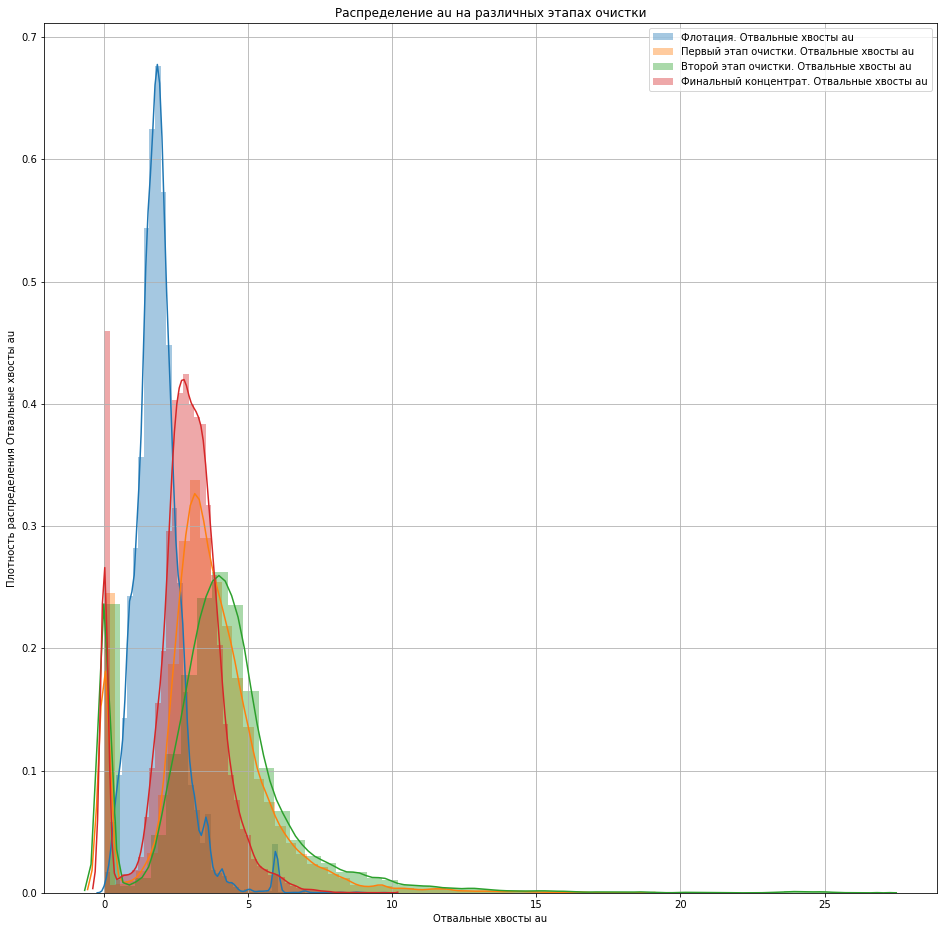

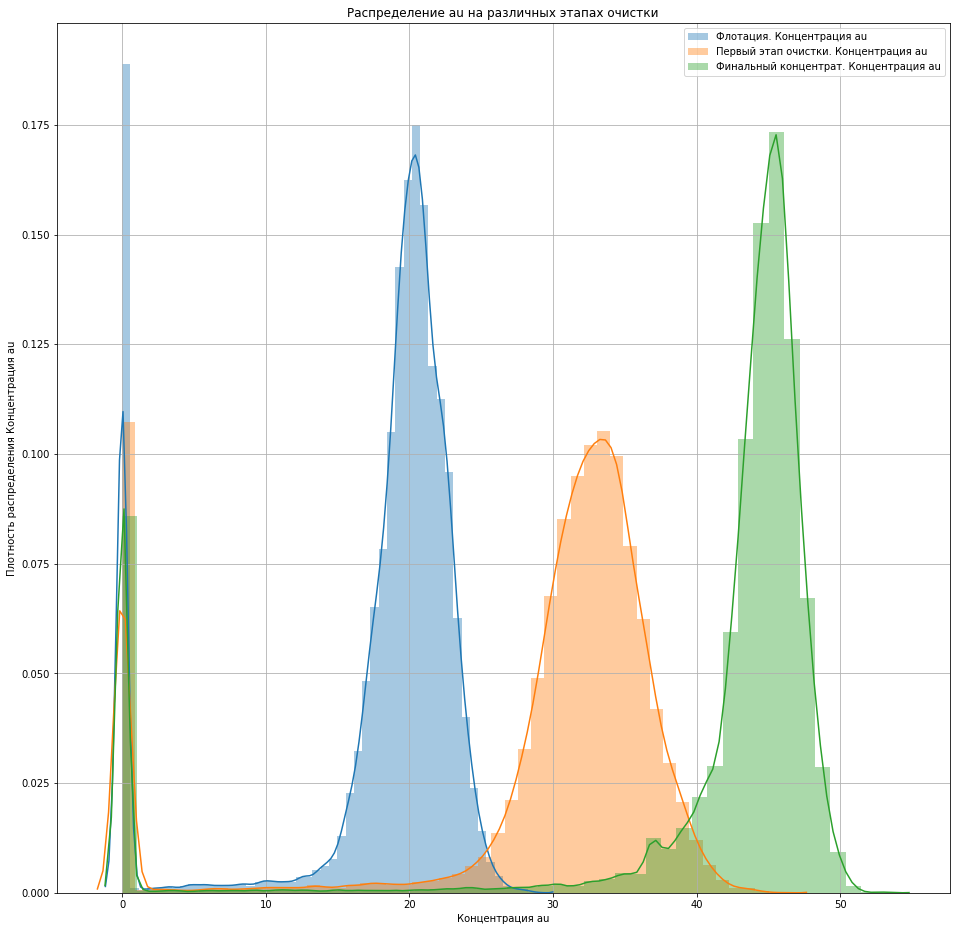

In [18]:
get_distributions(data_full, material='au')

**Выводы:**
1. Количество отвалившихся хвостов уменьшается на каждом этапе технологического процесса, что указывает на качество процесса и улучшение конечной концентрации золота;
2. Концентрация золота максимальна на финальном этапе очистке, что лишь подтверждает первый вывод;
3. Имееются аномалии вблизи 0. Эти данные скорее всего были получены на последних (по времени) итерациях производственного процесса близи его остановки, (остатки необработанного материала). Либо измерения были остановлены в какой-то момент времени, а эта руда ещё не успела претерпеть обработку. Подтверждением этого тезиса станет наличие таких же аномалий близи 0 при рассмотрении других материалов.

**`Ag`**

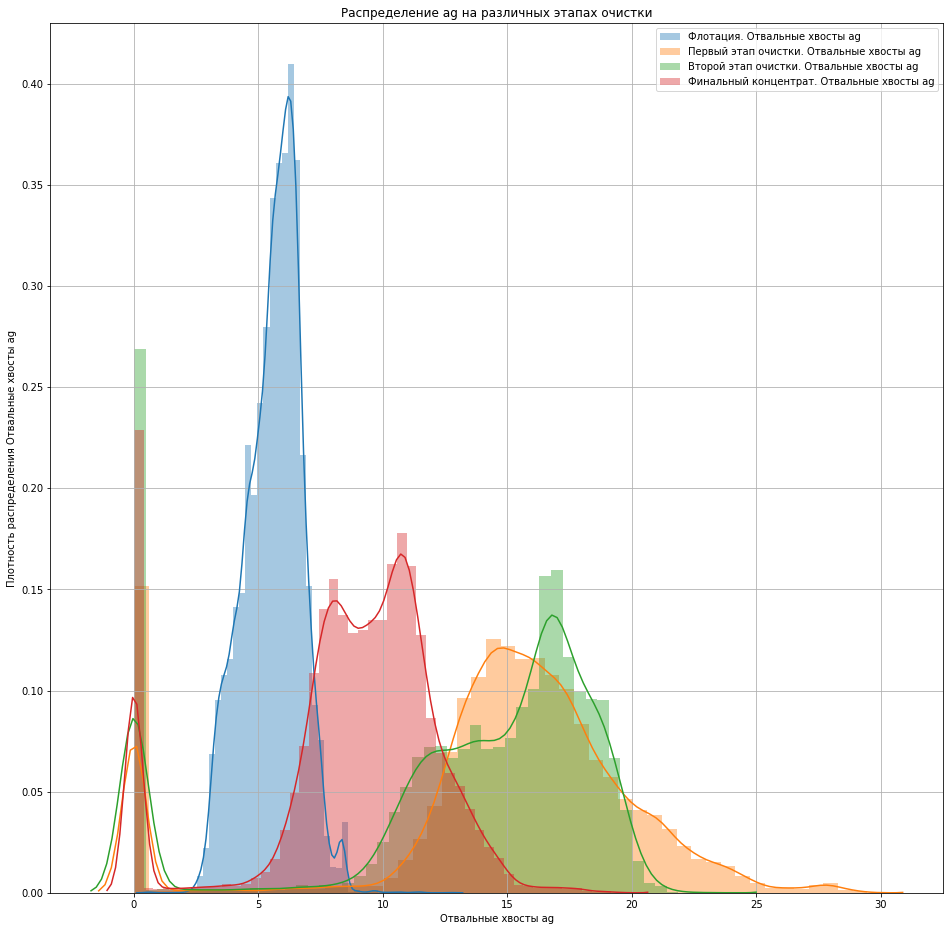

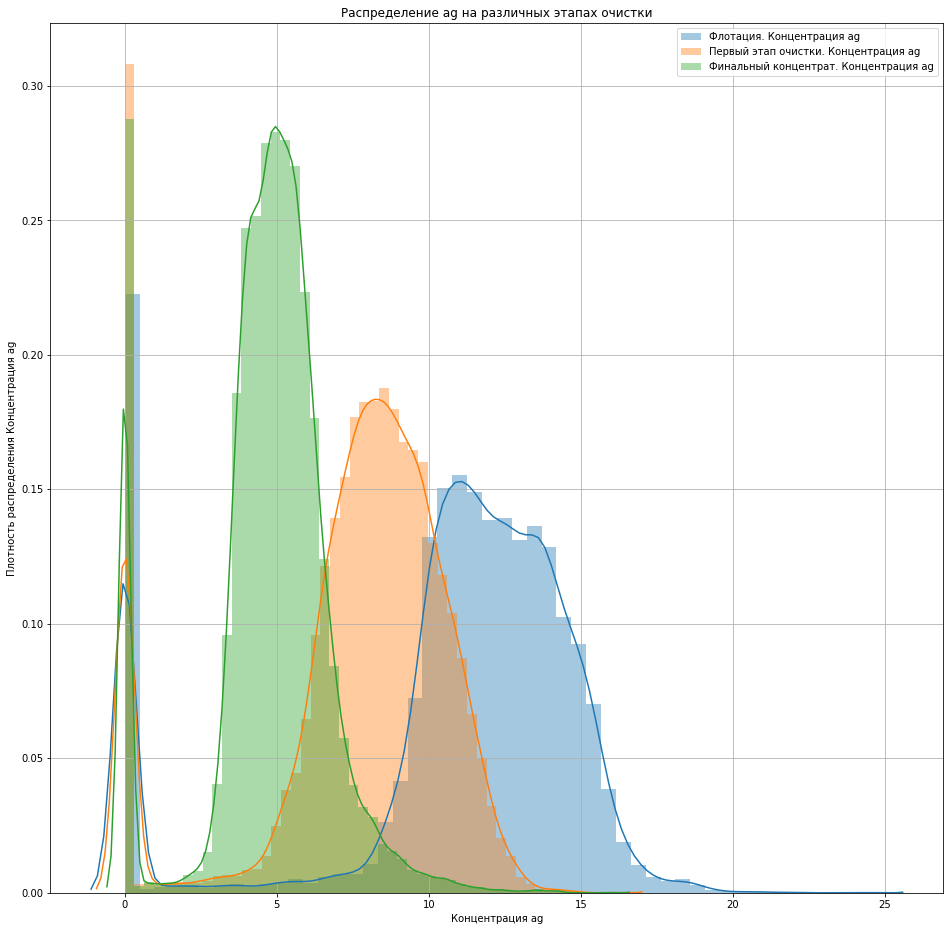

In [19]:
get_distributions(data_full, material='ag')

**Выводы:**
1. Количество отвалившихся хвостов уменьшается на каждом этапе технологического процесса, что указывает на качество процесса и улучшение конечной концентрации серебра;
2. Концентрация серебра уменьшается к финальному этапу очистки;
3. Имееются аномалии вблизи 0. Может служить подтверждением тезиса 3 выводов относительно золота.

**`Pb`**

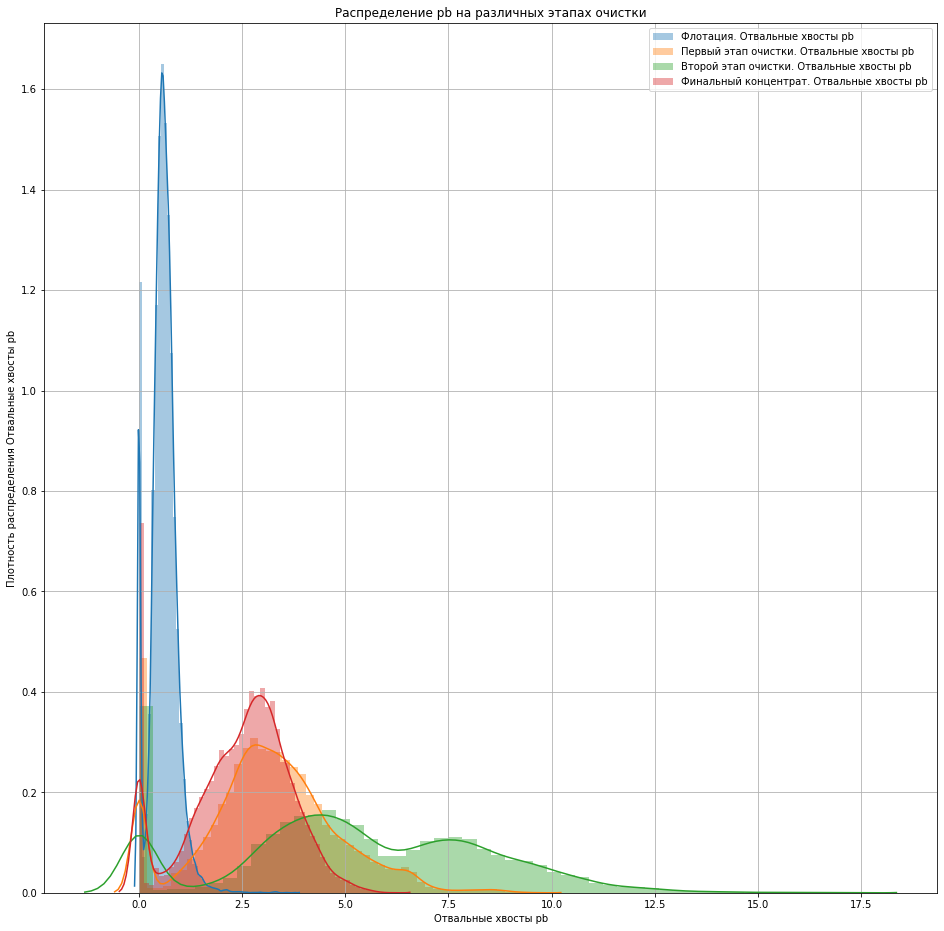

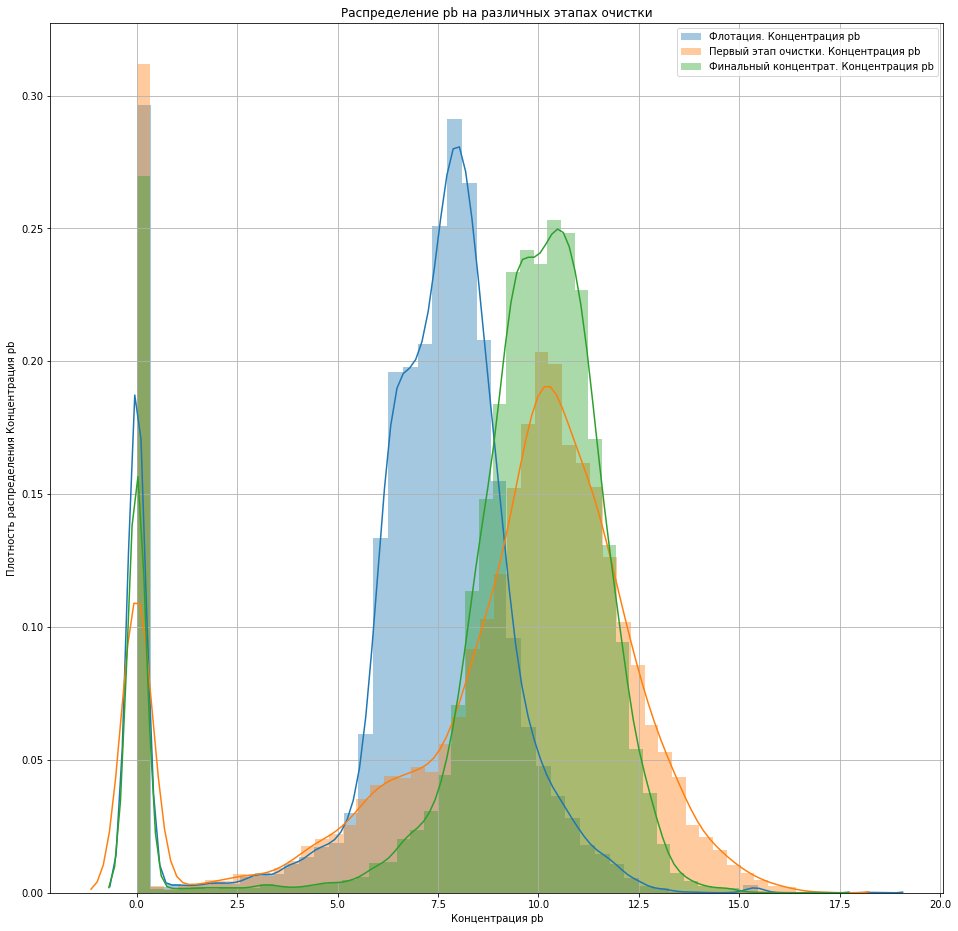

In [20]:
get_distributions(data_full, material='pb')

**Выводы:**
1. Количество отвалившихся хвостов уменьшается на каждом этапе технологического процесса, что указывает на качество процесса и улучшение конечной концентрации свинца;
2. Концентрация свинца уменьшается к финальному этапу очистки;
3. Имееются аномалии вблизи 0. Может служить подтверждением тезиса 3 выводов относительно золота.

**`Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках`**

In [21]:
data_feed_dict = {
    'Тренировочная' : data_train['rougher.input.feed_size'],
    'Тестовая' : data_test['rougher.input.feed_size']
}

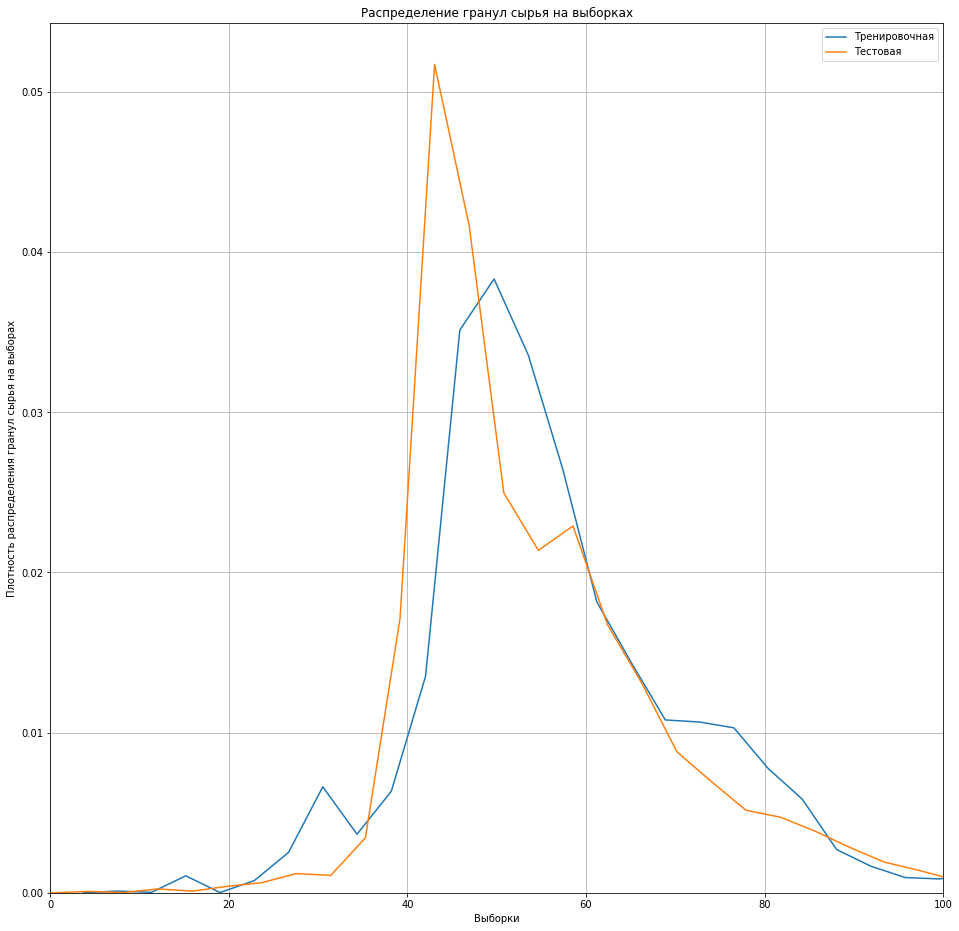

In [22]:
fig, ax = plt.subplots(figsize=(16, 16))

for d in data_feed_dict.items():
    sns.kdeplot(d[1], label=d[0])
ax.set_title('Распределение гранул сырья на выборках')
ax.set_ylabel('Плотность распределения гранул сырья на выборах')
ax.set_xlabel('Выборки')
plt.xlim(0, 100)
ax.legend()
plt.grid()

**Выводы:**
* Распределения на тренировочной и тестовой выборках имеют схожий вид, дисперсия на тренировочной выборке больше.

**`Исследование суммарной концентрации всех веществ на различных стадиях`**

Выделим суммарные концентрации веществ на каждом из этапов, отбросив аномалии близи 0 (про которые знаем из прошлого пункта)

In [23]:
input_concentrate = data_full[[
    'rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol'
]].sum(axis=1)
input_concentrate_norm = input_concentrate[input_concentrate > 1]

rougher_concentrate = data_full[[
    'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 
    'rougher.output.concentrate_au'
]].sum(axis=1)
rougher_concentrate_norm = rougher_concentrate[rougher_concentrate > 1]

final_concentrate = data_full[[
    'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 
    'final.output.concentrate_au'
]].sum(axis=1)
final_concentrate_norm = final_concentrate[final_concentrate > 1]

rougher_tails_concentrate = data_full[[
    'rougher.output.tail_ag', 'rougher.output.tail_pb', 'rougher.output.tail_sol', 'rougher.output.tail_au'
]].sum(axis=1)
rougher_tails_concentrate_norm = rougher_tails_concentrate[rougher_tails_concentrate > 1]

final_tails_concentrate = data_full[[
    'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol', 'final.output.tail_au'
]].sum(axis=1)
final_tails_concentrate_norm = final_tails_concentrate[final_tails_concentrate > 1]

In [24]:
data_concentrates_dict = {
    'Сырьё' : input_concentrate_norm,
    'Черновая стадия' : rougher_concentrate_norm,
    'Финальная стадия' : final_concentrate_norm,
    'Черновые хвосты' : rougher_tails_concentrate_norm,
    'Финальные хвосты' : final_tails_concentrate_norm
}

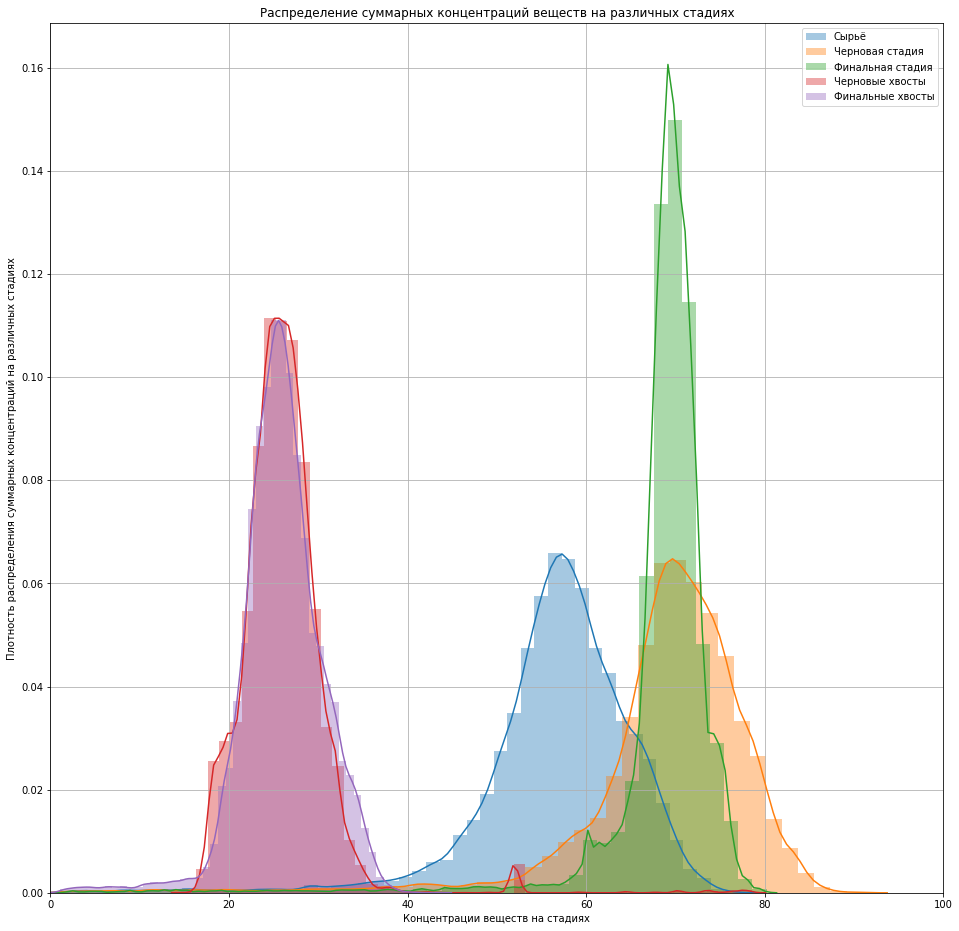

In [25]:
fig, ax = plt.subplots(figsize=(16, 16))

for d in data_concentrates_dict.items():
    sns.distplot(d[1], kde=True, label=d[0])
ax.set_title('Распределение суммарных концентраций веществ на различных стадиях')
ax.set_ylabel('Плотность распределения суммарных концентраций на различных стадиях')
ax.set_xlabel('Концентрации веществ на стадиях')
plt.xlim(0, 100)
ax.legend()
plt.grid()

**Выводы:**
1. Распределения черновых и финальных хвостов идентичны, что свидетельствует о работе технологического процесса;
2. Об этом же говорит и резкое увеление концентраций веществ на финальном этапе в сравнении с черновой стадией и сырьём.
3. Все распределения близки к нормальным, различающиеся значениями дисперсий, что является подходящим для дальнейшего построения моделей обучения.
___

<a id='section3'></a>
## 3. Построение модели

In [26]:
def smape(target, predicted):
    return np.sum(2 * np.abs(target - predicted) / (np.abs(target) + np.abs(predicted))) * 100 / len(target)


def final_smape(rougher, final):
    return 0.25 * rougher + 0.75 * final

In [27]:
data_train['year'] = pd.DatetimeIndex(data_train['date']).year
data_train['month'] = pd.DatetimeIndex(data_train['date']).month
data_train['day'] = pd.DatetimeIndex(data_train['date']).day
data_train['hour'] = pd.DatetimeIndex(data_train['date']).hour
data_train['minute'] = pd.DatetimeIndex(data_train['date']).minute
data_train['second'] = pd.DatetimeIndex(data_train['date']).second

data_train = data_train.drop('date', axis=1)

In [28]:
data_train.head()

final.output.concentrate_ag  final.output.concentrate_pb  \
0                     6.055403                     9.889648   
1                     6.029369                     9.968944   
2                     6.055926                    10.213995   
3                     6.047977                     9.977019   
4                     6.148599                    10.142511   

   final.output.concentrate_sol  final.output.concentrate_au  \
0                      5.507324                    42.192020   
1                      5.257781                    42.701629   
2                      5.383759                    42.657501   
3                      4.858634                    42.689819   
4                      4.939416                    42.774141   

   final.output.recovery  final.output.tail_ag  final.output.tail_pb  \
0              70.541216             10.411962              0.895447   
1              69.266198             10.462676              0.927452   
2              68.116445             10.507046              0.953716   
3              68.347543             10.422762              0.883763   
4              66.927016             10.360302              0.792826   

   final.output.tail_sol  final.output.tail_au  primary_cleaner.input.sulfate  \
0              16.904297              2.143149                     127.092003   
1              16.634514              2.224930                     125.629232   
2              16.208849              2.257889                     123.819808   
3              16.532835              2.146849                     122.270188   
4              16.525686              2.055292                     117.988169   

   ...  secondary_cleaner.state.floatbank5_b_air  \
0  ...                                  8.079666   
1  ...                                  7.984757   
2  ...                                  8.013877   
3  ...                                  7.977324   
4  ...                                  7.894242   

   secondary_cleaner.state.floatbank5_b_level  \
0                                 -500.470978   
1                                 -500.582168   
2                                 -500.517572   
3                                 -500.255908   
4                                 -500.356035   

   secondary_cleaner.state.floatbank6_a_air  \
0                                 14.151341   
1                                 13.998353   
2                                 14.028663   
3                                 14.005551   
4                                 13.996647   

   secondary_cleaner.state.floatbank6_a_level  year  month  day  hour  minute  \
0                                 -605.841980  2016      1   15     0       0   
1                                 -599.787184  2016      1   15     1       0   
2                                 -601.427363  2016      1   15     2       0   
3                                 -599.996129  2016      1   15     3       0   
4                                 -601.496691  2016      1   15     4       0   

   second  
0       0  
1       0  
2       0  
3       0  
4       0  

[5 rows x 92 columns]

In [29]:
# Нормализация признаков
scaler = StandardScaler()
scaler.fit(data_train)
data_train_scaled = pd.DataFrame(data=scaler.transform(data_train), index=data_train.index, columns=data_train.columns)
data_train_scaled.head()

final.output.concentrate_ag  final.output.concentrate_pb  \
0                     0.642225                     0.236002   
1                     0.629898                     0.259134   
2                     0.642473                     0.330619   
3                     0.638709                     0.261489   
4                     0.686353                     0.309766   

   final.output.concentrate_sol  final.output.concentrate_au  \
0                     -0.680429                     0.203646   
1                     -0.744289                     0.239801   
2                     -0.712051                     0.236670   
3                     -0.846434                     0.238963   
4                     -0.825762                     0.244946   

   final.output.recovery  final.output.tail_ag  final.output.tail_pb  \
0               0.309962              0.460013             -1.174972   
1               0.214449              0.473851             -1.148905   
2               0.128320              0.485957             -1.127515   
3               0.145632              0.462960             -1.184488   
4               0.039218              0.445919             -1.258551   

   final.output.tail_sol  final.output.tail_au  primary_cleaner.input.sulfate  \
0               1.776762             -0.417549                       0.122360   
1               1.714272             -0.353679                       0.095225   
2               1.615675             -0.327939                       0.061659   
3               1.690720             -0.414659                       0.032912   
4               1.689064             -0.486163                      -0.046522   

   ...  secondary_cleaner.state.floatbank5_b_air  \
0  ...                                 -0.678545   
1  ...                                 -0.693721   
2  ...                                 -0.689065   
3  ...                                 -0.694910   
4  ...                                 -0.708195   

   secondary_cleaner.state.floatbank5_b_level  \
0                                   -0.002484   
1                                   -0.003803   
2                                   -0.003037   
3                                    0.000066   
4                                   -0.001121   

   secondary_cleaner.state.floatbank6_a_air  \
0                                 -0.591174   
1                                 -0.612826   
2                                 -0.608536   
3                                 -0.611807   
4                                 -0.613067   

   secondary_cleaner.state.floatbank6_a_level      year     month       day  \
0                                   -1.047737 -1.235435 -1.577497 -0.081267   
1                                   -0.971164 -1.235435 -1.577497 -0.081267   
2                                   -0.991907 -1.235435 -1.577497 -0.081267   
3                                   -0.973806 -1.235435 -1.577497 -0.081267   
4                                   -0.992783 -1.235435 -1.577497 -0.081267   

       hour    minute    second  
0 -1.660698 -2.462369 -2.462369  
1 -1.516235 -2.462369 -2.462369  
2 -1.371772 -2.462369 -2.462369  
3 -1.227309 -2.462369 -2.462369  
4 -1.082846 -2.462369 -2.462369  

[5 rows x 92 columns]

In [30]:
# Масштабированные признаки
target_train_scaled_1 = data_train_scaled['rougher.output.recovery']
target_train_scaled_2 = data_train_scaled['final.output.recovery']
features_train_scaled = data_train_scaled.drop(different_cols, axis=1)

In [31]:
# Не масштабированные признаки
target_train_1 = data_train['rougher.output.recovery']
target_train_2 = data_train['final.output.recovery']
features_train = data_train.drop(different_cols, axis=1)

In [32]:
# Не масштабированные и без даты
data_train_wodate = data_train.drop(['year', 'month', 'day', 'hour', 'minute', 'second'], axis=1)
target_train_wodate_1 = data_train_wodate['rougher.output.recovery']
target_train_wodate_2 = data_train_wodate['final.output.recovery']
features_train_wodate = data_train_wodate.drop(different_cols, axis=1)

In [33]:
# Scoring
smape_score = make_scorer(smape, greater_is_better=False)

**`DecisionTreeRegressor`**

Выполним кросс-валидацию дерева решений относительно `rougher.output.recovery` и дальнейшее обучение модели на подобраных параметрах.

In [34]:
tree_params_dict = {
    "max_depth" : range(1, 41, 10),
    "min_samples_split" : range(2, 4),
    "min_samples_leaf" : range(1, 5)
}

In [35]:
def get_cross_val_score(model, features, target, param_grid, scoring):
    model_cv = GridSearchCV(
        model(random_state=271828),
        param_grid=param_grid,
        cv=4,
        scoring=scoring,
    )
    model_cv = model_cv.fit(features, target)
    print(
        'Гиперпараметры {}: {}'.format(type(model_cv).__name__, model_cv.best_params_),
        'Значение метрики smape = {:.2f}'.format(model_cv.best_score_),
        sep='\n'
    )
    model_best = model(**model_cv.best_params_, random_state=271828)
    model_best_smape = pd.Series(
        cross_val_score(
            model_best.fit(features, target),
            features, target,
            cv=10,
            scoring = scoring
        )
    )
    print('Среднее значение cross_validation_score = {:.2f}'.format(model_best_smape.mean()))
    return model_best, model_best_smape

Масштабированные призники

In [36]:
tree_best_scaled, tree_best_smape_scaled = get_cross_val_score(
    model=DecisionTreeRegressor,
    features=features_train_scaled,
    target=target_train_scaled_1,
    param_grid=tree_params_dict,
    scoring=smape_score
)

Гиперпараметры GridSearchCV: {'max_depth': 31, 'min_samples_leaf': 4, 'min_samples_split': 2}
Значение метрики smape = -126.11
Среднее значение cross_validation_score = -117.12


Не масштабированные признаки

In [37]:
tree_best, tree_best_smape = get_cross_val_score(
    model=DecisionTreeRegressor,
    features=features_train,
    target=target_train_1,
    param_grid=tree_params_dict,
    scoring=smape_score
)

Гиперпараметры GridSearchCV: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
Значение метрики smape = -19.69
Среднее значение cross_validation_score = -18.67


Не масштабированные и без даты

In [38]:
tree_best_wodate, tree_best_smape_wodate = get_cross_val_score(
    model=DecisionTreeRegressor,
    features=features_train_wodate,
    target=target_train_wodate_1,
    param_grid=tree_params_dict,
    scoring=smape_score
)

Гиперпараметры GridSearchCV: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
Значение метрики smape = -19.69
Среднее значение cross_validation_score = -18.67


In [39]:
def get_smape_distribution(data_dict, model_name : str):
    fig, ax = plt.subplots(figsize=(16, 16))

    for d in data_dict.items():
        sns.distplot(d[1], kde=True, label=d[0])
    ax.set_title('Распределение на кросс-валидации по метрике smape для %s'%model_name)
    ax.set_ylabel('Плотность распределения')
    ax.set_xlabel('Тип параметров')
    ax.legend()
    plt.grid()

In [40]:
tree_dict = {
    'Мастабированные параметры' :  tree_best_smape_scaled,
    'Не масштабированные параметры' : tree_best_smape,
    'Не масштабированные и без даты' : tree_best_smape_wodate,
}

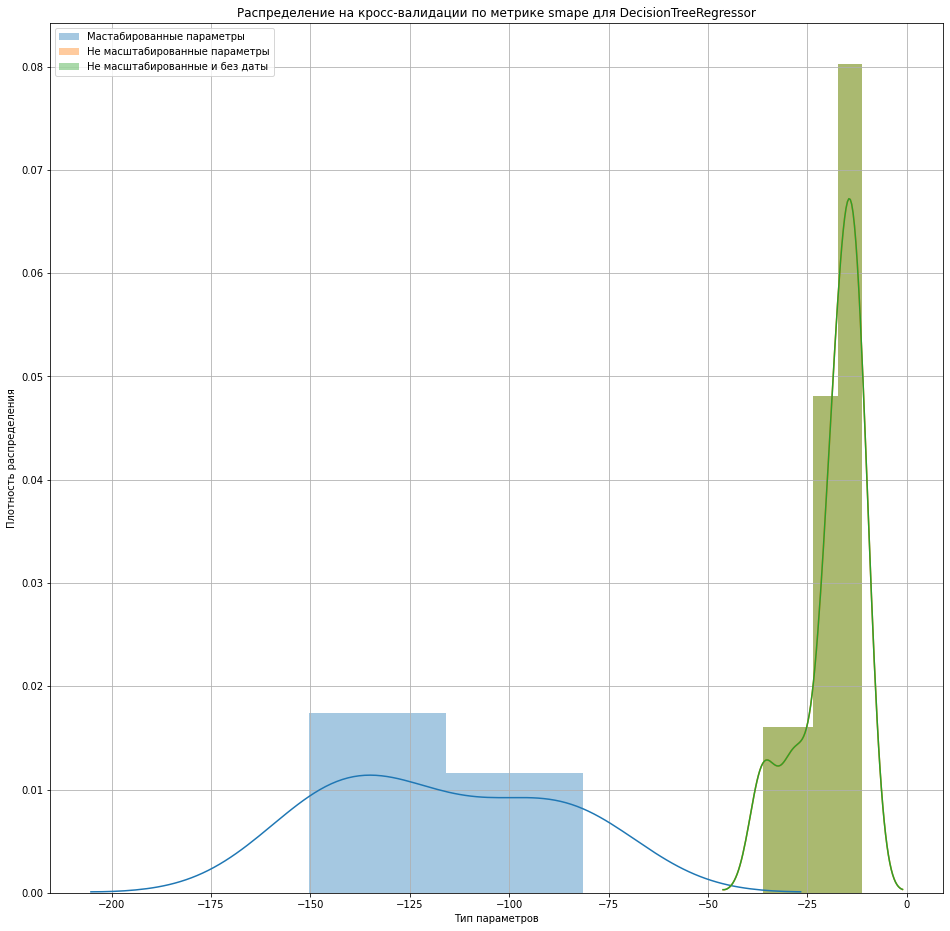

In [41]:
get_smape_distribution(tree_dict, 'DecisionTreeRegressor')

**Вывод:**  
* Ближе всего к нормальному распределение не масштабируемых признаков у Дерева решений. Не масштабируемые без даты - идентичны.

**`RandomForestRegressor`**

После прогона многих параметров на крупных/мелких шагах, лучшие результаты в областях малых значений гиперпараметров.

In [42]:
rf_params_dict = {
    "max_depth" : range(1, 5),
    "min_samples_split" : range(2, 4),
    "min_samples_leaf" : range(1, 4)
}

Масштабированные призники

In [43]:
rf_best_scaled, rf_best_smape_scaled = get_cross_val_score(
    model=RandomForestRegressor,
    features=features_train_scaled,
    target=target_train_scaled_1,
    param_grid=rf_params_dict,
    scoring=smape_score
)

Гиперпараметры GridSearchCV: {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2}
Значение метрики smape = -132.73
Среднее значение cross_validation_score = -130.86


Не масштабированные признаки

In [44]:
rf_best, rf_best_smape = get_cross_val_score(
    model=RandomForestRegressor,
    features=features_train,
    target=target_train_1,
    param_grid=rf_params_dict,
    scoring=smape_score
)

Гиперпараметры GridSearchCV: {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2}
Значение метрики smape = -18.77
Среднее значение cross_validation_score = -16.90


Не масштабированные и без даты

In [45]:
rf_best_wodate, rf_best_smape_wodate = get_cross_val_score(
    model=RandomForestRegressor,
    features=features_train_wodate,
    target=target_train_wodate_1,
    param_grid=rf_params_dict,
    scoring=smape_score
)

Гиперпараметры GridSearchCV: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Значение метрики smape = -18.73
Среднее значение cross_validation_score = -17.44


In [46]:
rf_dict = {
    'Мастабированные параметры' :  rf_best_smape_scaled,
    'Не масштабированные параметры' : rf_best_smape,
    'Не масштабированные и без даты' : rf_best_smape_wodate,
}

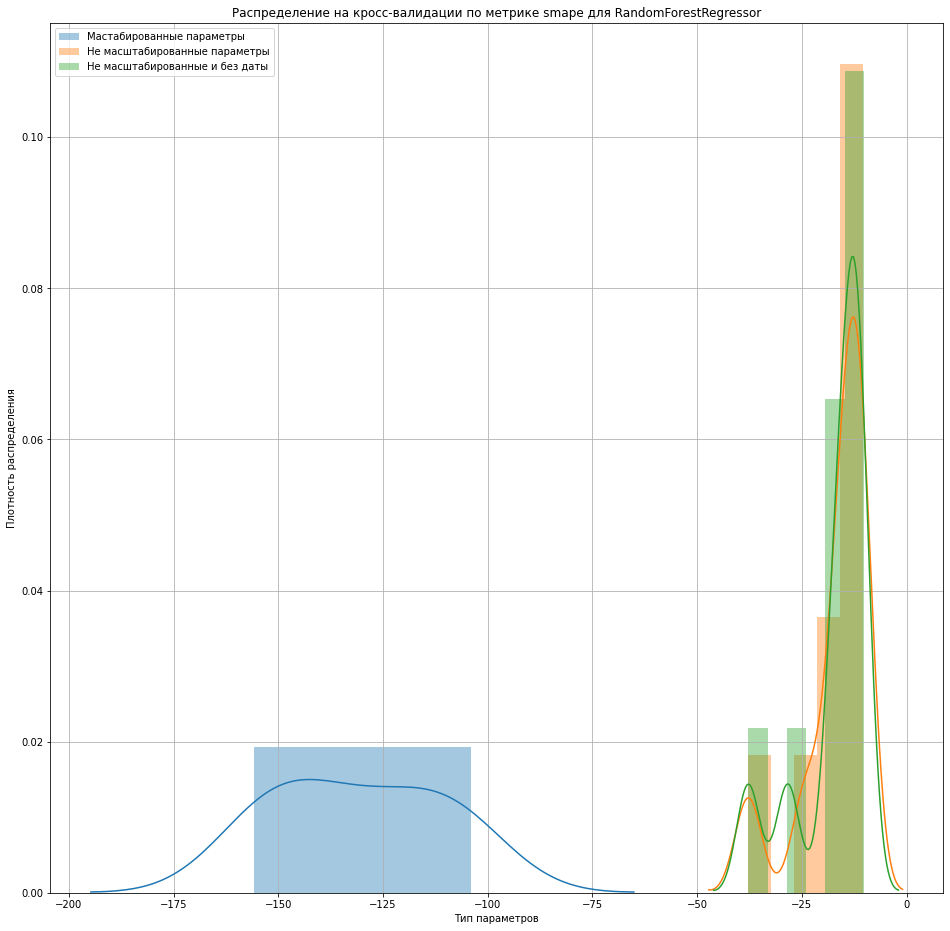

In [47]:
get_smape_distribution(rf_dict, 'RandomForestRegressor')

**Вывод:**  
* Ближе всего к нормальному распределение не масштабируемых признаков у Случайного леса. Не масштабируемые без даты - имеют 2 выраженных побочных пика слева. Вдобавок не масштабируемые признаки имеют наилучшее значение `cross_validation_score`.

**`LinearRegression`**

Масштабированные признаки

In [48]:
linear_reg_scaled = LinearRegression()
try:
    linear_reg_best_scaled = linear_reg_scaled.fit(features_train_scaled, target_train_scaled_1)
except np.linalg.LinAlgError:
    linear_reg_best_scaled = linear_reg_scaled.fit(features_train_scaled, target_train_scaled_1)
linear_reg_best_scaled_smape = pd.Series(
    cross_val_score(
        linear_reg_best_scaled,
        features_train, target_train_1,
        cv=10,
        scoring = smape_score
    )
)
print('Среднее значение cross_validation_score = {:.2f}'.format(linear_reg_best_scaled_smape.mean()))

Среднее значение cross_validation_score = -19.01


Не масштабированные признаки

In [49]:
linear_reg = LinearRegression()
linear_reg_best = linear_reg.fit(features_train, target_train_1)
linear_reg_best_smape = pd.Series(
    cross_val_score(
        linear_reg_best,
        features_train, target_train_1,
        cv=10,
        scoring = smape_score
    )
)
print('Среднее значение cross_validation_score = {:.2f}'.format(linear_reg_best_smape.mean()))

Среднее значение cross_validation_score = -19.01


Не масштабированные и без даты

In [50]:
linear_reg = LinearRegression()
linear_reg_best_wodate = linear_reg.fit(features_train_wodate, target_train_wodate_1)
linear_reg_best_wodate_smape = pd.Series(
    cross_val_score(
        linear_reg_best,
        features_train_wodate, target_train_wodate_1,
        cv=10,
        scoring = smape_score
    )
)
print('Среднее значение cross_validation_score = {:.2f}'.format(linear_reg_best_wodate_smape.mean()))

Среднее значение cross_validation_score = -18.31


In [51]:
linear_dict = {
    'Мастабированные параметры' :  linear_reg_best_scaled_smape,
    'Не масштабированные параметры' : linear_reg_best_smape,
    'Не масштабированные и без даты' : linear_reg_best_wodate_smape,
}

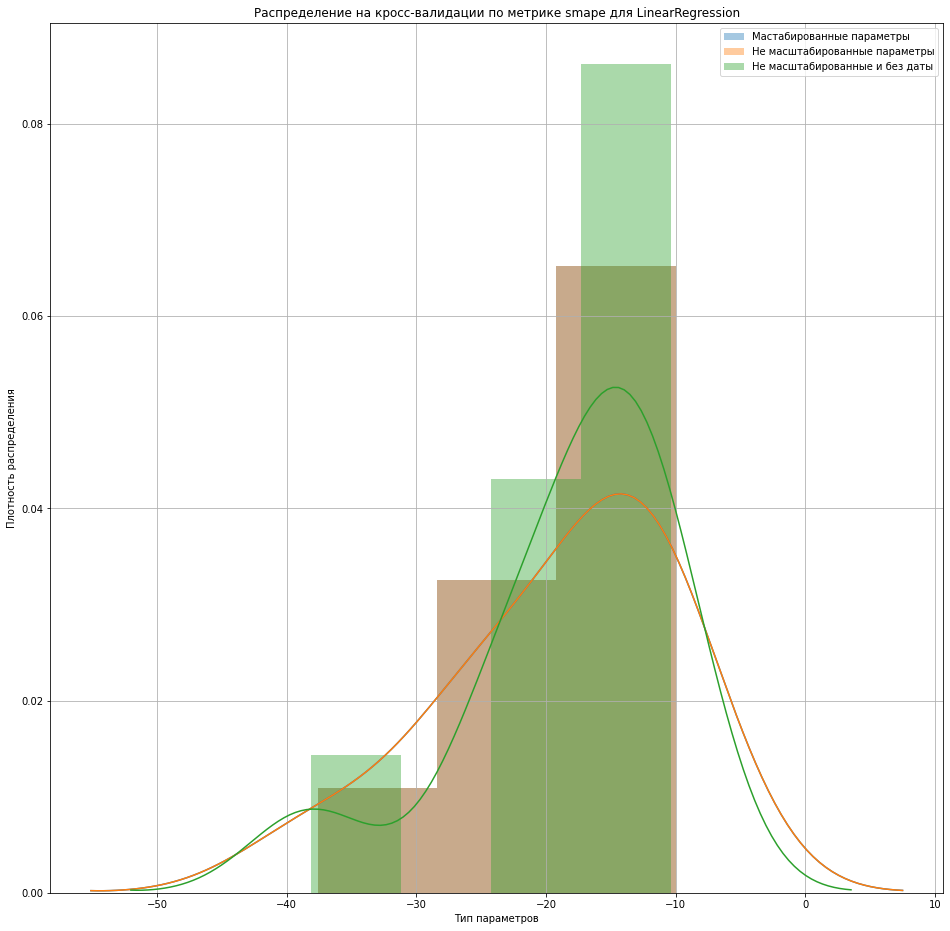

In [52]:
get_smape_distribution(linear_dict, 'LinearRegression')

**Вывод:**
* Не масштабируемые параметры имеют наилучшее приближение к нормальному распределению, (подобно остальным со смещением вправо), среди всех обученных моделей.

Посмотрим на все выбранные распределения моделей.

In [53]:
train_dict = {
    'Не масштабированные параметры DecisionTreeRegressor' : tree_best_smape,
    'Не масштабированные параметры RandomForestRegressor' : rf_best_smape,
    'Не масштабированные параметры LinearRegression' : linear_reg_best_smape,
    'Не масштабированные параметры без даты LinearRegression' : linear_reg_best_wodate_smape
}

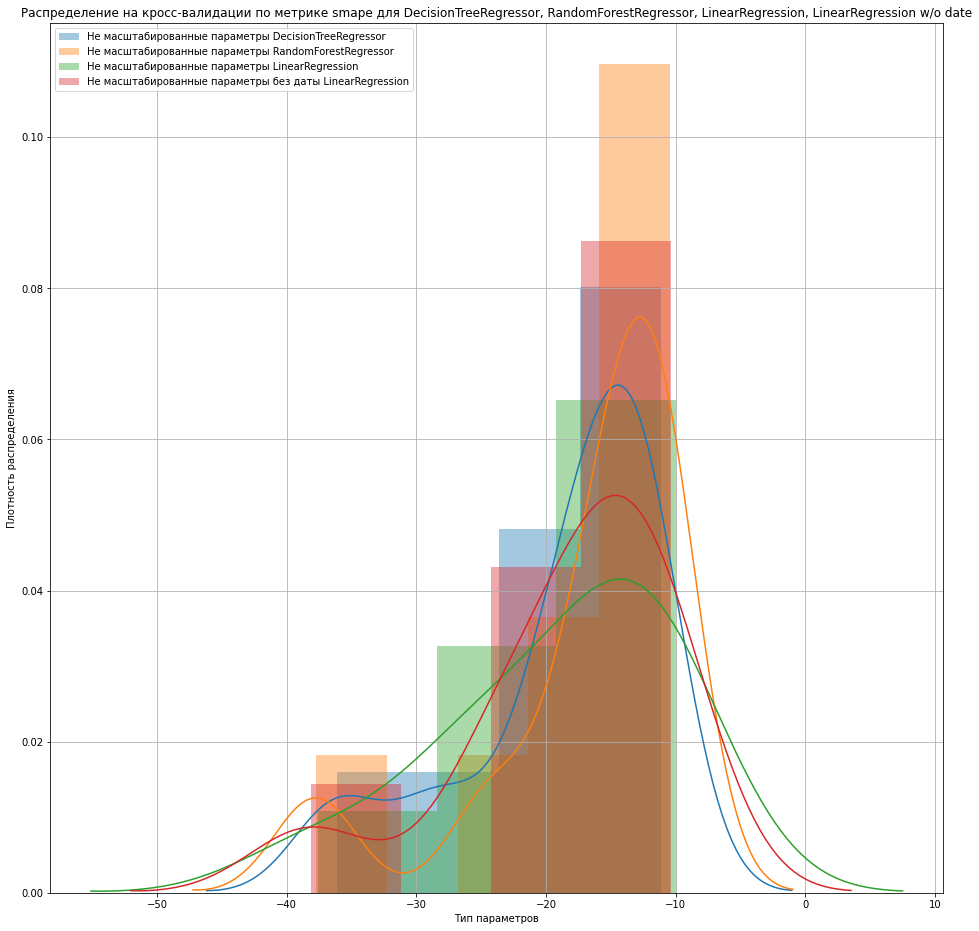

In [54]:
get_smape_distribution(train_dict, 'DecisionTreeRegressor, RandomForestRegressor, LinearRegression, LinearRegression w/o date')

**Результаты:**  
* Из представленных и обученных моделей линейная регрессия для не масштабируемых признаков больше остальных справляется со смещённым пиком слева, уподобляясь нормальному распределению.
* Модель случайного леса для не масштабируемых признаков выделяет ярко выраженный пик, однако имеет побочный в районе `(-45, -35)`, имея при этом наилучшие показатели по метрике `SMAPE`. 

В дальнейшем будут использоваться эти 2 модели.

**Проверка на тестовой выборке**

In [55]:
rf_best, linear_reg_best_wodate

(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=271828,
                       verbose=0, warm_start=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False))

**`rougher.output.recovery`**

In [56]:
# Восстановление по дате тестовой выборки из полного набора данных.
data_test_date = data_test['date']
data_full_date = data_full['date']
data_test_full = data_full[data_full_date.isin(data_test_date)]

In [57]:
# Благодаря этому получаем target_test_1 --- rougher.output.recovery.
target_test_1 = data_test_full['rougher.output.recovery'].reset_index(drop=True)

In [58]:
data_test['year'] = pd.DatetimeIndex(data_test['date']).year
data_test['month'] = pd.DatetimeIndex(data_test['date']).month
data_test['day'] = pd.DatetimeIndex(data_test['date']).day
data_test['hour'] = pd.DatetimeIndex(data_test['date']).hour
data_test['minute'] = pd.DatetimeIndex(data_test['date']).minute
data_test['second'] = pd.DatetimeIndex(data_test['date']).second

features_test = data_test.drop('date', axis=1)

In [59]:
rf_rougher_recovery_predicted = pd.Series(rf_best.predict(features_test), index=target_test_1.index)
linear_rougher_recovery_predicted = pd.Series(linear_reg_best.predict(features_test), index=target_test_1.index)

In [60]:
# Вычисление SMAPE для rougher.output.recovert на тестовом датасета
smape_rf_rougher_test = smape(target_test_1, rf_rougher_recovery_predicted)
smape_linear_reg_rougher_test = smape(target_test_1, linear_rougher_recovery_predicted)

In [61]:
print(
    'SMAPE on RandomForestRegressor = {:.2f}%'.format(smape_rf_rougher_test),
    'SMAPE on LinearRegression = {:.2f}%'.format(smape_linear_reg_rougher_test),
    sep='\n'
)

SMAPE on RandomForestRegressor = 11.40%
SMAPE on LinearRegression = 22.79%


Проверка на адекватность средним

In [62]:
const_pred = pd.Series([target_test_1.median()] * len(target_test_1), index=target_test_1.index)

In [63]:
smape_const = smape(target_test_1, const_pred)
print('SMAPE on Const Median Prediction = {:.2f}%'.format(smape_const))

SMAPE on Const Median Prediction = 8.96%


**Результаты:**  
Обе модели прошли проверку на адекватность в сравнении с медианным предсказанием.

**`final.output.recovery`**

In [64]:
target_test_2 = data_full[data_full_date.isin(data_test_date)]['final.output.recovery']

rougher_predicted_rf = pd.DataFrame(rf_rougher_recovery_predicted, index=features_test.index)
rougher_predicted_linear = pd.DataFrame(linear_rougher_recovery_predicted, index=features_test.index)

**`RandomForestRegressor`**

In [65]:
params_rf = rf_best.get_params()
rf = RandomForestRegressor(**params_rf)

In [66]:
rf.fit(features_train, target_train_2);

In [67]:
rf_final_recovery_predicted = rf.predict(features_test)

In [68]:
smape_rf_final_test = smape(target_test_2, rf_final_recovery_predicted)

In [69]:
print('SMAPE on RandomForestRegressor = {:.2f}%'.format(smape_rf_final_test))

SMAPE on RandomForestRegressor = 12.21%


**`LinearRegression`**

In [70]:
lr = LinearRegression()

In [71]:
features_train_wodate

primary_cleaner.input.sulfate  primary_cleaner.input.depressant  \
0                         127.092003                         10.128295   
1                         125.629232                         10.296251   
2                         123.819808                         11.316280   
3                         122.270188                         11.322140   
4                         117.988169                         11.913613   
...                              ...                               ...   
16855                     123.381787                          8.028927   
16856                     120.878188                          7.962636   
16857                     105.666118                          7.955111   
16858                      98.880538                          7.984164   
16859                      95.248427                          8.078957   

       primary_cleaner.input.feed_size  primary_cleaner.input.xanthate  \
0                                 7.25                        0.988759   
1                                 7.25                        1.002663   
2                                 7.25                        0.991265   
3                                 7.25                        0.996739   
4                                 7.25                        1.009869   
...                                ...                             ...   
16855                             6.50                        1.304232   
16856                             6.50                        1.302419   
16857                             6.50                        1.315926   
16858                             6.50                        1.241969   
16859                             6.50                        1.283045   

       primary_cleaner.state.floatbank8_a_air  \
0                                 1549.775757   
1                                 1576.166671   
2                                 1601.556163   
3                                 1599.968720   
4                                 1601.339707   
...                                       ...   
16855                             1648.421193   
16856                             1649.820162   
16857                             1649.166761   
16858                             1646.547763   
16859                             1648.759906   

       primary_cleaner.state.floatbank8_a_level  \
0                                   -498.912140   
1                                   -500.904965   
2                                   -499.997791   
3                                   -500.951778   
4                                   -498.975456   
...                                         ...   
16855                               -400.382169   
16856                               -399.930973   
16857                               -399.888631   
16858                               -398.977083   
16859                               -399.862053   

       primary_cleaner.state.floatbank8_b_air  \
0                                 1551.434204   
1                                 1575.950626   
2                                 1600.386685   
3                                 1600.659236   
4                                 1601.437854   
...                                       ...   
16855                             1648.742005   
16856                             1649.357538   
16857                             1649.196904   
16858                             1648.212240   
16859                             1650.135395   

       primary_cleaner.state.floatbank8_b_level  \
0                                   -516.403442   
1                                   -499.865889   
2                                   -500.607762   
3                                   -499.677094   
4                                   -500.323246   
...                                         ...   
16855                               -400.359661   
16856                         

In [72]:
try:
    lr.fit(features_train, target_train_2);
except np.linalg.LinAlgError:
    lr.fit(features_train, target_train_2);

In [73]:
lr_final_recovery_predicted = lr.predict(features_test)

In [74]:
smape_lr_final_test = smape(target_test_2, lr_final_recovery_predicted)

In [75]:
print('SMAPE on RandomForestRegressor = {:.2f}%'.format(smape_lr_final_test))

SMAPE on RandomForestRegressor = 15.95%


Проверка моделей на адекватность.

In [76]:
const_pred = pd.Series([target_test_2.median()] * len(target_test_2), index=target_test_2.index)

In [77]:
smape_const = smape(target_test_2, const_pred)
print('SMAPE on Const Median Prediction = {:.2f}%'.format(smape_const))

SMAPE on Const Median Prediction = 12.45%


**Результат:**  
Случайный лес выдал неадекватные значения на предсказании `final.output.recovery`. Линейная регрессия по прежнему показывает хорошие и адекватные результаты. Посмотрим на `final_smape`.

In [78]:
final_smape_rf = final_smape(smape_rf_rougher_test, smape_rf_final_test)
final_smape_linear = final_smape(smape_linear_reg_rougher_test, smape_lr_final_test)

In [79]:
print(
    'Final SMAPE on RandomForestRegression = {:.2f}%'.format(final_smape_rf),
    'Final SMAPE on LinearRegression = {:.2f}%'.format(final_smape_linear),
    sep='\n'
)

Final SMAPE on RandomForestRegression = 12.01%
Final SMAPE on LinearRegression = 17.66%


<a id='section4'></a>
## 4. Выводы исследования

**Результат:**  

**1.`Первичный осмотр данных:`**  
   1. Была проведена предобработка данных от пропусков;
   2. Произведена оценка рассчитанной эффективности обогащения золота. Результаты сошлись с табличными, вследствие чего данные внушают доверие;
   3. Из тестовой выборки были исключены признаки, отвечающие за технологический процесс;
   
**2. `Анализ данных:`**  
   1. Количество отвалившихся хвостов уменьшается на каждом этапе технологического процесса, что указывает на качество процесса и улучшение конечной концентрации золота, серебра и свинца;
   2. Концентрация золота возрастает с каждым этапом и максимальна на финальном этапе. У серебра и свинца обратная ситуация - их концентрации минимальны на финальном этапе; 
   3. Имееются аномалии вблизи 0. Эти данные скорее всего были получены на последних (по времени) итерациях производственного процесса близи его остановки, (остатки необработанного материала). Либо измерения были остановлены в какой-то момент времени, а эта руда ещё не успела претерпеть обработку. Подтверждением этого тезиса является наличие таких же аномалий близи 0 при рассмотрении серебра и свинца;
   4. Распределения черновых и финальных хвостов идентичны, что свидетельствует о работе технологического процесса; об этом же говорит и резкое увеление концентраций веществ на финальном этапе в сравнении с черновой стадией и сырьём.
   5. Все распределения концентраций веществ близки к нормальным, различающиеся значениями дисперсий, что является подходящим для дальнейшего построения моделей обучения.
   
**3. `Построение модели:`**   
   1. Распределения на тренировочной и тестовой выборках имеют схожий вид, дисперсия на тренировочной выборке больше.
   2. Не масштабируемые параметры имеют наилучшее приближение к нормальному распределению, (подобно остальным со смещением вправо), среди всех обученных моделей.
   3. Ближе всего к нормальному распределение не масштабируемых признаков у Случайного леса. Не масштабируемые без даты - имеют 2 выраженных побочных пика слева. Вдобавок не масштабируемые признаки имеют наилучшее значение `cross_validation_score`.
   4. Ближе всего к нормальному распределение не масштабируемых признаков у Дерева решений. Не масштабируемые без даты - идентичны.
   5. Из представленных и обученных моделей линейная регрессия для не масштабируемых признаков больше остальных справляется со смещённым пиком слева, уподобляясь нормальному распределению.
   6. Модель случайного леса для не масштабируемых признаков выделяет ярко выраженный пик, однако имеет побочный в районе `(-45, -35)`, имея при этом наилучшие показатели по метрике `SMAPE`. 
   7. Итоговые значения SMAPE:  
       $LinearRegression = 17.66\%$;  
       $RandomForestRegressor = 12.01\%$  
   8. В результате работы, реконмендуется использование модели линейной регрессии на немасштаблируемых признаках.